# Using machine learning to classify the morphologies of distant galaxies

Data set: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
REBUILD_DATA = False

## Setting up data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Galaxy Classification/training_solutions_rev1.csv")
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


Probability distributions for the classifications for each of the training images.

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)

In [5]:
df_train.shape, df_test.shape

((49262, 38), (12316, 38))

* Split training data into ~50,000 images for training, and ~12,000 images for validation
* Each row corresponds to a specific galaxy (each with a unique GalaxyID)
* Each galaxy (row) has 37 probabilities corresponding to each class of galaxy

In [6]:
ORIGINAL_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

X1 = (ORIGINAL_SHAPE[0] - CROP_SIZE[0]) // 2  # x coordinate of cropped image
Y1 = (ORIGINAL_SHAPE[1] - CROP_SIZE[1]) // 2  # y coordinate of cropped image

In [7]:
from skimage.transform import resize
from tqdm import tqdm

def process_image(path, x1, y1, shape, crop_size):
    img = plt.imread(path)  # reads image from file path
    img = img[x1:x1+crop_size[0], y1:y1+crop_size[1]]  # crops image
    img = resize(img, shape)  # resizes image
    img = img/255.0  # normalises
    return img

def get_all_images(df, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    all_values = df.values  # removes column headers
    ids = all_values[:,0].astype(int).astype(str)
    y = all_values[:,1:]
    X = []
    
    for img_id in tqdm(ids):
        img = process_image("data/images_training_rev1/"+img_id+".jpg", X1, Y1, shape, crop_size)
        X.append(img)
        
    X = np.array(X)
    
    return X, y

In [8]:
if REBUILD_DATA:
    X_train, y_train = get_all_images(df_train)
    X_test, y_test = get_all_images(df_test)
    np.save("X_train.npy", X_train)
    np.save("y_train.npy", y_train)
    np.save("X_test.npy", X_test)
    np.save("y_test.npy", y_test)

In [9]:
X_train = np.load("/content/drive/MyDrive/Galaxy Classification/X_train.npy")
y_train = np.load("/content/drive/MyDrive/Galaxy Classification/y_train.npy")
X_test = np.load("/content/drive/MyDrive/Galaxy Classification/X_test.npy")
y_test = np.load("/content/drive/MyDrive/Galaxy Classification/y_test.npy")

## Exploratory data analysis (EDA)

In [10]:
columns = df.columns[1:]  # removes GalaxyID column
columns

Index(['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
       'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
       'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
       'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
       'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')

In [11]:
def show_image(idx):
  """
  Takes an image from X_train at index=idx and denormalises it so that it can be displayed
  Takes the prediction and its respective probability and outputs as the title
  """
  img = X_train[idx]*255
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  label = columns[np.argmax(y_train[idx])]
  conf = np.max(y_train[idx])
  plt.title(f"{label} with {round(conf*100, 2)}% confidence")

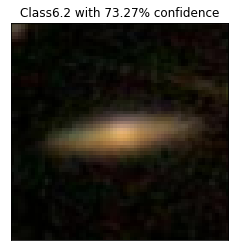

In [12]:
show_image(3)

## Building the neural network

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D

In [14]:
len(columns)

37

37 classes^

In [15]:
model = Sequential()

model.add(Conv2D(512, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())

model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(37))
model.add(Activation('sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adamax", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 512)       14336     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 256)       1179904   
_________________________________________________________________
activation (Activation)      (None, 60, 60, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       295040    
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 128)       0

In [16]:
history = model.fit(X_train, y_train, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
1540/1540 [==============================] - 222s 120ms/step - loss: 0.3376 - accuracy: 0.5227 - val_loss: 0.2949 - val_accuracy: 0.5992
Epoch 2/8
1540/1540 [==============================] - 180s 117ms/step - loss: 0.2972 - accuracy: 0.5939 - val_loss: 0.2889 - val_accuracy: 0.5992
Epoch 3/8
1540/1540 [==============================] - 180s 117ms/step - loss: 0.2913 - accuracy: 0.5987 - val_loss: 0.2833 - val_accuracy: 0.6301
Epoch 4/8
1540/1540 [==============================] - 180s 117ms/step - loss: 0.2825 - accuracy: 0.6082 - val_loss: 0.2648 - val_accuracy: 0.6595
Epoch 5/8
1540/1540 [==============================] - 181s 117ms/step - loss: 0.2687 - accuracy: 0.6292 - val_loss: 0.2603 - val_accuracy: 0.7012
Epoch 6/8
1540/1540 [==============================] - 181s 117ms/step - loss: 0.2610 - accuracy: 0.6692 - val_loss: 0.2535 - val_accuracy: 0.7250
Epoch 7/8
1540/1540 [==============================] - 181s 118ms/step - loss: 0.2573 - accuracy: 0.6952 - val_loss: 0

In [18]:
import time
model.save(f"/content/drive/MyDrive/Galaxy Classification/model-{int(time.time())}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Galaxy Classification/model-1619720448/assets


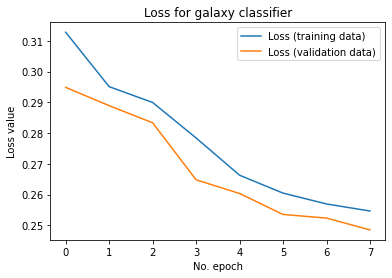

In [19]:
plt.plot(history.history["loss"], label="Loss (training data)")
plt.plot(history.history["val_loss"], label="Loss (validation data)")
plt.title("Loss for galaxy classifier")
plt.ylabel("Loss value")
plt.xlabel("No. epoch")
plt.legend(loc="upper right");

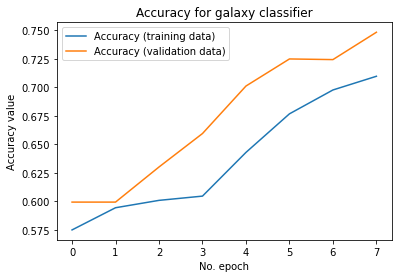

In [20]:
plt.plot(history.history["accuracy"], label="Accuracy (training data)")
plt.plot(history.history["val_accuracy"], label="Accuracy (validation data)")
plt.title("Accuracy for galaxy classifier")
plt.ylabel("Accuracy value")
plt.xlabel("No. epoch")
plt.legend(loc="upper left");